In [3]:
#导入包
%matplotlib inline
import torch
import torch.nn as nn 
import pandas as pd 
import numpy as np 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os


import matplotlib


import matplotlib.pyplot as plt
import torchvision.models as models
#This is for the progress bar
from tqdm import tqdm
import seaborn as sns

# matplotlib.use('Qt5Agg')

In [4]:
import zipfile
import os
def un_zip(file_name):
    """unzip zip file"""
    base_dir = os.path.dirname(file_name)
    zip_file = zipfile.ZipFile(file_name, 'r')
    os.makedirs(os.path.join(*file_name.split('.')[:-1])   ,exist_ok=True )
    zip_file.extractall(os.path.join(*file_name.split('.')[:-1]) )

un_zip('classify-leaves.zip')
len(os.listdir('classify-leaves'))

4

In [1]:
!pip install matplotlib
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json  /root/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c classify-leaves 

     |████████████████████████████████| 58 kB 2.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=a71b56a0815308d2e07e36472e213af1a765056c1118f2cfc22f45e1ed7d5469
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 98% 193M/197M [00:06<00:00, 44.8MB/s]
100% 197M/197M [00:06<00:00, 29.7MB/s]


In [5]:
# 看label文件长什么样
labels_dataframe = pd.read_csv('classify-leaves/train.csv')
labels_dataframe.head(5)

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [ ]:
labels_dataframe.describe()

In [ ]:
#function to show bar length
def barw(ax):
    for p in ax.patches:
        val = p.get_width()
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()
        ax.annotate(round(val,2),(x,y))  # 标注文本/值  文本位置 （可使用箭头等）
plt.figure(figsize = (15,40))
ax0 = sns.countplot(y=labels_dataframe['label'], order=labels_dataframe['label'].value_counts().index)

barw(ax0)
plt.show()


In [6]:
# 把label文件排个序
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_class = len(leaves_labels)
print(n_class)
leaves_labels[:10]

176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [7]:
#将labels转换成对应数字
class_to_num = dict(zip(leaves_labels, range(n_class)))
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [8]:
num_to_class = {v : k for k, v in class_to_num.items()}


In [ ]:
class_to_num

In [28]:
# 创建dataset
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', 
                 valid_ratio=0.2, resize_height=256, resize_width=256):
        """Args:
                csv_path (string): csv 文件
                file_path (sting): 图像所在路径
                mode (string): 训练模式还是测试模式
                valid (float): 验证集比例
        """
        # 需要调整后的照片尺寸， 
        self.resize_height = resize_height
        self.resize_width = resize_width
        
        
        self.file_path = file_path
        self.mode = mode
        
        #读取 csv 文件
        #pandas读取
        self.data_info = pd.read_csv(csv_path, header=None)#去掉表头， image，label 在第一行
        # 计算length
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            # 第一列包含图像文件的名称
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])
            #self.data_info.iloc[1:, 0]
            #表示读取第一列，从第二行开始到train_len
            # 第二列是图像的 label
            
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image
            self.label_arr = self.train_label
            
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])

            self.image_arr = self.valid_image 
            self.label_arr = self.valid_label

        elif mode == 'test':
            self.test_image = self.data_info.iloc[1:, 0]
            self.image_arr = self.test_image
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'.format(mode, self.real_len))


    def __getitem__(self, index):
        # 从 image_arr 中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        image_as_img = Image.open(self.file_path + single_image_name)
#         image_as_img.ndim
        #如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
    #     if img_as_img.mode != 'L':
    #         img_as_img = img_as_img.convert('L')    

        #设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        #数据增强
        if self.mode == 'trian':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5), #随机翻转 概率
                transforms.ToTensor()
            ])
        else:
            # valid  test  不做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])

            img_as_img = transform(image_as_img)
            
        if self.mode == 'test':
            return img_as_img
        else:

            label = self.label_arr[index]
            number_label = class_to_num[label]

            return img_as_img, number_label #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len

In [29]:
train_path = 'classify-leaves/train.csv'
test_path = 'classify-leaves/test.csv'
# csv 文件中已经含有 /images 路径， 
img_path = 'classify-leaves/'
  
train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')

print(train_dataset)
print(val_dataset)
print(test_dataset)


Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


In [ ]:
# 定义 data loader
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=2
)
val_loader = torch.utils.data.DataLoader(
        dataset= val_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=2
)
test_loder = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=2
)

In [ ]:
# val_dataset[10]

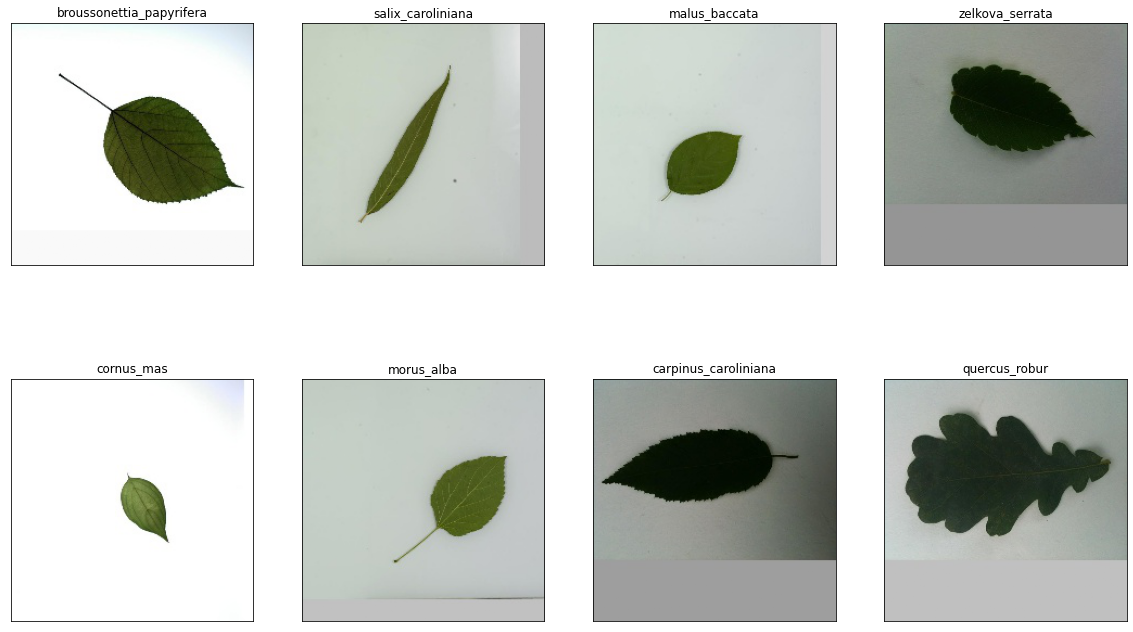

In [33]:
# 给大家展示一下数据长啥样
# 给大家展示一下数据长啥样
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(val_loader)
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [47]:
#查看在 cpu 还还是在 gpu
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

cuda


In [43]:
# 是否要冻住模型前一些层
def set_parameter_requirs_grad(model, feature_extracting):  
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad=False

# res-34模型
def res_model(num_classes, feature_extract = False, use_pretrained=True):
    model_ft = models.resnet34(pretrained=use_pretrained)
    set_parameter_requirs_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features   # 卷积层输出特征数
    
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))
    
    return model_ft


In [96]:
# 超参数

learning_rate = 3e-4
weight_decay = 1e-3
num_epoch = 50
model_path = 'pre_res_model.ckpt'

In [ ]:
# 初始化模型  放入设备
#Initialize a model , and put it on the device specified

model = res_model(176)
model = model.to(device)
model.device = device
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(),lr = learning_rate, 
                         weight_decay=weight_decay)

n_epochs = num_epoch

best_acc = 0.0


for epoch in range(n_epochs):
    #-------Training---------
    # make sure the model is trian mode before training.
    model.train()
    #These are used to resred information in training.
    train_loss = []
    train_accs = []
    #iterater the training set by batches
    for batch in tqdm(train_loader):
        # A batch consists of image data and  corresponding label
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Forward the data.(Make sure data and model are on the same device.)
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it automatically.
        loss = criterion(logits, labels)
        
        optim.zero_grad()
        
        loss.backward()
        optim.step()
        
        acc = (logits.argmax(dim=-1) == labels).float().mean()  #一个批次的平均acc
        
        #Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    #the average loss and accuracy of the training set is the average of the recordedvalue.abs
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    
    #Print the information.

    print(f"[Train | {epoch + 1:03d}/{n_epochs:03d} ]  loss = {train_loss:.5f}, acc = {train_acc:.5f}")
          
 #----------Validation--------
    
    model.eval()
          
    valid_loss = []
    valid_accs = []
          
    #Iterate the validation set by batches
    for batch in tqdm(val_loader):
        imgs ,labels =  batch
          
        with torch.no_grad():
            logits = model(imgs.to(device))
          
        loss = criterion(logits, labels.to(device))
          
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        # Record  loss and acc.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    valid_los = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    
    print(f"[Valid | {epoch + 1:03d}/{n_epochs:03d} ]  loss = {valid_los:.5f}, acc = {valid_acc:.5f}")
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))

100%|██████████| 1836/1836 [05:28<00:00,  5.59it/s]


[Train | 001/050 ]  loss = 2.79258, acc = 0.31182


100%|██████████| 459/459 [00:28<00:00, 15.86it/s]


[Valid | 001/050 ]  loss = 1.85405, acc = 0.46296
saving model with acc 0.463


100%|██████████| 1836/1836 [05:28<00:00,  5.59it/s]


[Train | 002/050 ]  loss = 1.49915, acc = 0.31182


100%|██████████| 459/459 [00:28<00:00, 15.86it/s]


[Valid | 002/050 ]  loss = 1.53344, acc = 0.57489
saving model with acc 0.575


100%|██████████| 1836/1836 [05:29<00:00,  5.58it/s]


[Train | 003/050 ]  loss = 1.09372, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.62it/s]


[Valid | 003/050 ]  loss = 1.16822, acc = 0.64406
saving model with acc 0.644


100%|██████████| 1836/1836 [05:28<00:00,  5.59it/s]


[Train | 004/050 ]  loss = 0.85165, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.77it/s]


[Valid | 004/050 ]  loss = 1.18941, acc = 0.65659
saving model with acc 0.657


100%|██████████| 1836/1836 [05:29<00:00,  5.58it/s]


[Train | 005/050 ]  loss = 0.68258, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.71it/s]


[Valid | 005/050 ]  loss = 1.01653, acc = 0.71868
saving model with acc 0.719


100%|██████████| 1836/1836 [05:29<00:00,  5.57it/s]


[Train | 006/050 ]  loss = 0.57613, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.64it/s]


[Valid | 006/050 ]  loss = 0.97417, acc = 0.72576
saving model with acc 0.726


100%|██████████| 1836/1836 [05:29<00:00,  5.56it/s]


[Train | 007/050 ]  loss = 0.49787, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.74it/s]


[Valid | 007/050 ]  loss = 0.87383, acc = 0.74837
saving model with acc 0.748


100%|██████████| 1836/1836 [05:30<00:00,  5.56it/s]


[Train | 008/050 ]  loss = 0.43325, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.71it/s]


[Valid | 008/050 ]  loss = 0.95712, acc = 0.73284


100%|██████████| 1836/1836 [05:30<00:00,  5.56it/s]


[Train | 009/050 ]  loss = 0.37871, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.76it/s]


[Valid | 009/050 ]  loss = 0.86726, acc = 0.74591


100%|██████████| 1836/1836 [05:29<00:00,  5.57it/s]


[Train | 010/050 ]  loss = 0.34852, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.82it/s]


[Valid | 010/050 ]  loss = 0.85818, acc = 0.75000
saving model with acc 0.750


100%|██████████| 1836/1836 [05:30<00:00,  5.56it/s]


[Train | 011/050 ]  loss = 0.32055, acc = 0.31182


100%|██████████| 459/459 [00:28<00:00, 15.85it/s]


[Valid | 011/050 ]  loss = 0.82535, acc = 0.76280
saving model with acc 0.763


100%|██████████| 1836/1836 [05:29<00:00,  5.57it/s]


[Train | 012/050 ]  loss = 0.30922, acc = 0.31182


100%|██████████| 459/459 [00:28<00:00, 15.95it/s]


[Valid | 012/050 ]  loss = 0.90295, acc = 0.76144


100%|██████████| 1836/1836 [05:29<00:00,  5.58it/s]


[Train | 013/050 ]  loss = 0.29038, acc = 0.31182


100%|██████████| 459/459 [00:28<00:00, 15.98it/s]


[Valid | 013/050 ]  loss = 0.85970, acc = 0.76280


100%|██████████| 1836/1836 [05:30<00:00,  5.56it/s]


[Train | 014/050 ]  loss = 0.26388, acc = 0.31182


100%|██████████| 459/459 [00:28<00:00, 15.93it/s]


[Valid | 014/050 ]  loss = 0.79888, acc = 0.76988
saving model with acc 0.770


100%|██████████| 1836/1836 [05:26<00:00,  5.63it/s]


[Train | 015/050 ]  loss = 0.26918, acc = 0.31182


100%|██████████| 459/459 [00:28<00:00, 16.08it/s]


[Valid | 015/050 ]  loss = 0.83166, acc = 0.77996
saving model with acc 0.780


100%|██████████| 1836/1836 [05:27<00:00,  5.61it/s]


[Train | 016/050 ]  loss = 0.25164, acc = 0.31182


100%|██████████| 459/459 [00:28<00:00, 15.85it/s]


[Valid | 016/050 ]  loss = 0.92791, acc = 0.75163


100%|██████████| 1836/1836 [05:31<00:00,  5.53it/s]


[Train | 017/050 ]  loss = 0.23722, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.81it/s]


[Valid | 017/050 ]  loss = 0.90210, acc = 0.75899


100%|██████████| 1836/1836 [05:29<00:00,  5.57it/s]


[Train | 018/050 ]  loss = 0.23261, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.66it/s]


[Valid | 018/050 ]  loss = 0.84712, acc = 0.77233


100%|██████████| 1836/1836 [05:31<00:00,  5.54it/s]


[Train | 019/050 ]  loss = 0.23445, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.60it/s]


[Valid | 019/050 ]  loss = 0.98433, acc = 0.74537


100%|██████████| 1836/1836 [05:31<00:00,  5.54it/s]


[Train | 020/050 ]  loss = 0.21105, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.54it/s]


[Valid | 020/050 ]  loss = 0.84636, acc = 0.77288


100%|██████████| 1836/1836 [05:31<00:00,  5.54it/s]


[Train | 021/050 ]  loss = 0.21980, acc = 0.31182


100%|██████████| 459/459 [00:29<00:00, 15.71it/s]


[Valid | 021/050 ]  loss = 0.82514, acc = 0.77315


 47%|████▋     | 861/1836 [02:35<02:55,  5.54it/s]

2.711782406552944


In [ ]:
SaveFileName = 'classify-leaves/submiss.csv'

In [ ]:
## predict 
model = res_model(176)

# create model and load weights from checkpoint
model = model.to(device)
model.load_state_dict(torch.load(model_path))


# Make sure the modell is in eval mode.

model.eval()

predictions = []

for batch in tqdm(test_loader)
  img = batch
  with torch.no_grad():
    logits = model(img.to(device))
  predictions.extend(logits.argmax(dim=-1)).cpu().numpy().tolist())
preds = []
for i in predictions:
  preds.append(num_to_class[i])

test_data = pd.read_csv(test_path)
test_data['label'] = pd.Series(preds)

submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(SaveFileName, index=Flase)
print('Done!!!!!!!!!!!!!!!!!!!!!!!!!!!')

In [ ]:
# api 提交比赛结果
!kaggle competitions submit -c classify-leaves -f submission.csv -m "First Submit!"